In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import *
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import ExtraTreesRegressor
from catboost import Pool, CatBoostClassifier

pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)

# 1.0 Data retrieval

In [2]:
df = pd.read_pickle('../../data_lake/output/2_dp.pkl')

In [3]:
df.sample(1)

,LBE,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,DS,DP,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,CLASS,NSP
SegFile,,,,,,,,,,,,,,,,,,,,,,,,
CTG0420.txt,137.0,137.0,1.0,0.0,1.0,63.0,0.5,9.0,7.8,0.0,0.0,0.0,75.0,125.0,200.0,4.0,0.0,146.0,144.0,146.0,2.0,-1.0,10.0,2.0


# 2.0 Data preparation

In [4]:
for i in df:
    if df[i].dtype == 'object':
        df[i] = df[i].astype(str)

# 3.0 Modeling
## 3.1 Classe 1

In [5]:
df1 = df

In [6]:
df1['NSP'] = df['NSP'].mask((df['NSP'] == '2.0') | (df['NSP'] == '3.0'),'0.0')

In [7]:
df1['NSP'].value_counts()

1.0    1655
0.0     471
Name: NSP, dtype: int64

In [10]:
df_under = df1[df1['NSP']=='0.0']
df_over = df1[df1['NSP']=='1.0']
df_over = df_over.sample(frac=df_under.shape[0]/df_over.shape[0],random_state=0)
df2 = df_over.append(df_under).sample(frac=1)

In [11]:
df2['NSP'].value_counts()

0.0    471
1.0    471
Name: NSP, dtype: int64

In [12]:
# df2['NSP'] = df2['NSP'].mask(df2['NSP']=='3.0','1.0')

In [13]:
X = df2.drop(columns=['NSP'])
y = df2[['NSP']]

In [14]:
# pip install catboost

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.4, random_state = 1)

In [17]:
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_train.select_dtypes(include=['object', 'bool']).columns

In [18]:
numerical_preprocessor = Pipeline(steps=[("imputer", IterativeImputer(ExtraTreesRegressor(n_estimators=5,random_state=1,verbose=0),random_state=1,verbose=0,add_indicator=True)),
                                     ("scaler", MinMaxScaler())])
categorical_preprocessor = Pipeline(steps=[("imputer", SimpleImputer(strategy='constant', fill_value='missing',verbose=0,add_indicator=True)),
                                       ("label_enc", OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[
                                           ("categorical_preprocessor", categorical_preprocessor, categorical_cols)])
preprocessor = ColumnTransformer(transformers=[("numerical_preprocessor", numerical_preprocessor, numerical_cols),
                                           ("categorical_preprocessor", categorical_preprocessor, categorical_cols)])

In [19]:
pipe_model = CatBoostClassifier(iterations=500, 
                           loss_function='Logloss', 
                           eval_metric='Accuracy',
                           verbose=False,
                           early_stopping_rounds=50,
                           depth=3,
                           random_state=1)

In [20]:
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('model', pipe_model)])

In [21]:
model.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical_preprocessor',
                                                  Pipeline(steps=[('imputer',
                                                                   IterativeImputer(add_indicator=True,
                                                                                    estimator=ExtraTreesRegressor(n_estimators=5,
                                                                                                                  random_state=1),
                                                                                    random_state=1)),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['LBE', 'LB', 'AC', 'FM', 'UC', 'ASTV', 'MSTV', 'ALTV', 'MLTV', 'DL',
       'DS', 'DP', 'Width', 'Min', '...de', 'Mean',
     

In [22]:
parameters = {'model__depth':[2,3],'model__iterations':[500,1000]}

In [24]:
model_grid = GridSearchCV(model,parameters,cv=3,scoring='accuracy',verbose=0,return_train_score=True).fit(X_train,y_train)
print('GridSearchCV results...')
print("Mean Train Scores: \n{}\n".format(model_grid.cv_results_['mean_train_score']))
print("Mean Test Scores: \n{}\n".format(model_grid.cv_results_['mean_test_score']))

GridSearchCV results...
Mean Train Scores: 
[0.99203774 0.99203774 0.99646331 0.99646331]

Mean Test Scores: 
[0.98056212 0.97878907 0.98056212 0.98233517]



In [25]:
print('Test results...')
y_test_predict_grid = model_grid.predict(X_test)

Test results...


Model Test Accuracy: 0.9814323607427056
--------------------------------------------------
Model Test Confusion Matrix


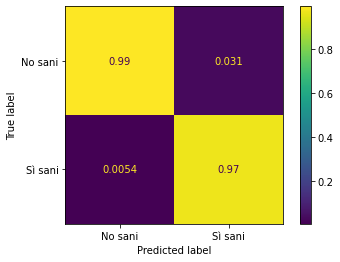

In [26]:
print("Model Test Accuracy:", metrics.accuracy_score(y_test, y_test_predict_grid))
print('--------------------------------------------------')
print('Model Test Confusion Matrix')
cm = confusion_matrix(y_test,y_test_predict_grid,normalize='pred') 
cmd = ConfusionMatrixDisplay(cm,display_labels=['No sani','Sì sani'])
cmd.plot()

In [38]:
feature_importances = model_grid.best_estimator_.named_steps['model'].get_feature_importance()
feature_names = X_train.columns
lista = []
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
#         print('{}: {}'.format(name, score))
        lista.append(name)
print('Di seguito le prime 10 features per importanza:')
print(lista[0:10])

Di seguito le prime 10 features per importanza:
['AC', 'MSTV', 'ALTV', 'ASTV', 'DP', 'Mean', 'Mode', 'UC', 'Median', 'DL']


In [28]:
df['proba_classe_1'] = 0
df['proba_classe_1'] = model_grid.predict_proba(df[X_test.columns])[:,1]

In [29]:
df.sample(1)

,LBE,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,DS,DP,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,CLASS,NSP,proba_classe_1
SegFile,,,,,,,,,,,,,,,,,,,,,,,,,
CTG1719.txt,131.0,131.0,10.0,1.0,4.0,55.0,2.0,0.0,2.7,1.0,0.0,0.0,85.0,84.0,169.0,6.0,0.0,132.0,140.0,145.0,26.0,1.0,2.0,1.0,0.992508


<AxesSubplot:>

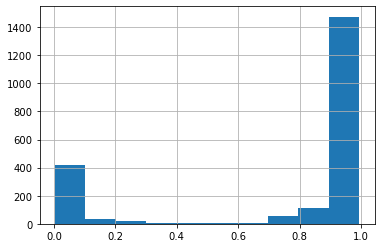

In [31]:
df['proba_classe_1'].hist()

Faccio funzioni

In [33]:
def model_preparation(df,classe_nsp):
    """
    
    """
    df1 = df
    if classe_nsp == '1.0':
        df1['NSP'] = df['NSP'].mask((df['NSP'] == '2.0') | (df['NSP'] == '3.0'),'0.0')
    elif classe_nsp == '2.0':
        df1['NSP'] = df['NSP'].mask((df['NSP'] == '1.0') | (df['NSP'] == '3.0'),'0.0')
    else:
        df1['NSP'] = df['NSP'].mask((df['NSP'] == '2.0') | (df['NSP'] == '1.0'),'0.0')
    
    ## Bilanciamento classi
    df_under = df1[df1['NSP']==df1['NSP'].value_counts().index[1]]
    df_over = df1[df1['NSP']==df1['NSP'].value_counts().index[0]]
    df_over = df_over.sample(frac=df_under.shape[0]/df_over.shape[0],random_state=0)
    df2 = df_over.append(df_under).sample(frac=1)
    
    ## Definizione label
    if classe_nsp == '2.0':
        df2['NSP'] = df2['NSP'].mask(df2['NSP']=='2.0','1.0')
    elif classe_nsp == '3.0':
        df2['NSP'] = df2['NSP'].mask(df2['NSP']=='3.0','1.0')
    else:
        pass
    
    return df2

In [40]:
def model_training(df):
    """
    
    """
    X = df.drop(columns=['NSP'])
    y = df[['NSP']]
    pritn(X.shape)
    
    ##
    if X.shape[0] > 800:
        X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.35, random_state = 1)
        parameters = {'model__depth':[3,4],'model__iterations':[500,1000]}
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.45, random_state = 1)
        parameters = {'model__depth':[2,3],'model__iterations':[400,600]}
    
    ##
    numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
    categorical_cols = X_train.select_dtypes(include=['object', 'bool']).columns
    
    ##
    numerical_preprocessor = Pipeline(steps=[("imputer", IterativeImputer(ExtraTreesRegressor(n_estimators=5,random_state=1,verbose=0),random_state=1,verbose=0,add_indicator=True)),
                                     ("scaler", MinMaxScaler())])
    categorical_preprocessor = Pipeline(steps=[("imputer", SimpleImputer(strategy='constant', fill_value='missing',verbose=0,add_indicator=True)),
                                           ("label_enc", OneHotEncoder(handle_unknown='ignore'))])
    preprocessor = ColumnTransformer(transformers=[("numerical_preprocessor", numerical_preprocessor, numerical_cols),
                                               ("categorical_preprocessor", categorical_preprocessor, categorical_cols)])
    pipe_model = CatBoostClassifier(iterations=500, loss_function='Logloss', eval_metric='Accuracy',verbose=False,early_stopping_rounds=50,depth=3,random_state=1)
    
    ##
    model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('model', pipe_model)])
    ##
    model.fit(X_train,y_train)
    model_grid = GridSearchCV(model,parameters,cv=3,scoring='accuracy',verbose=0,return_train_score=True).fit(X_train,y_train)
    print('GridSearchCV results...')
    print("Mean Train Scores: \n{}\n".format(model_grid.cv_results_['mean_train_score']))
    print("Mean Test CV Scores: \n{}\n".format(model_grid.cv_results_['mean_test_score']))
    
    return model_grid, X_test, y_test

In [39]:
def model_evaluation(model,X_test,y_test):
    """
    
    """
    print('Test results...')
    y_test_predict_grid = model.predict(X_test)    
    print("Model Test Accuracy:", metrics.accuracy_score(y_test, y_test_predict_grid))
    print('--------------------------------------------------')
    print('Model Test Confusion Matrix')
    cm = confusion_matrix(y_test,y_test_predict_grid,normalize='pred') 
    cmd = ConfusionMatrixDisplay(cm,display_labels=['No sani','Sì sani'])
    cmd.plot()
    
    ##
    feature_importances = model_grid.best_estimator_.named_steps['model'].get_feature_importance()
    feature_names = X_test.columns
    lista = []
    for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    #         print('{}: {}'.format(name, score))
            lista.append(name)
    print('Di seguito le prime 10 features per importanza:')
    print(lista[0:10])
    
    return model

In [41]:
def model_serving(df,model,classe_nsp,X_test):
    """
    
    """
    classe_nsp = str(classe_nsp)
    df['proba_classe_'+classe_nsp] = 0
    df['proba_classe_'+classe_nsp] = model.predict_proba(df[X_test.columns])[:,1]
    
    return df